## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import optuna
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [ ]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Read dataset

In [ ]:
df_xgboost = pd.read_csv("GOOG.csv")

In [ ]:
df_xgboost.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
1,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
3,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
4,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401


## Prepare Data

In [ ]:
#calculate return from one day ago
df_xgboost["Return"] = df_xgboost["Close"]/df_xgboost["Close"].shift(1) -1

In [ ]:
df_xgboost.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488,NaN
1,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939,0.010064
2,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159,-0.041408
3,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512,0.010775
4,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401,0.018019


In [ ]:
#Convert year, month, day into numerical values
df_xgboost["Date"] = pd.to_datetime(df_xgboost["Date"])

df_xgboost["Year"] = df_xgboost["Date"].dt.year
df_xgboost["Month"] = df_xgboost["Date"].dt.month
df_xgboost["Day"] = df_xgboost["Date"].dt.day




In [ ]:
#engineer features to be one day behind
df_xgboost["Prev Adj Close"] = df_xgboost["Adj Close"].shift(1)
df_xgboost["Prev Close"] = df_xgboost["Close"].shift(1)
df_xgboost['Prev Volume'] = df_xgboost['Volume'].shift(1)
df_xgboost['Prev Open'] = df_xgboost['Open'].shift(1)
df_xgboost['Prev Volume'] = df_xgboost['Prev Volume'].apply(lambda x: 0 if x == 0 else np.log(x))

#standardize adj close, close, and open
scaler = StandardScaler()
df_xgboost[['Prev Adj Close', 'Prev Close', 'Prev Open']] = scaler.fit_transform(df_xgboost[['Prev Adj Close', 'Prev Close', 'Prev Open']])

# scaler = StandardScaler()
# df[['Prev Close', 'Prev Volume']] = scaler.fit_transform(df[['Prev Close', 'Prev Volume']])

#find the rolling averages 1 day behind for close
df_xgboost['5d Close Rolling Mean'] = df_xgboost['Close'].rolling(window=5).mean().shift(1)
df_xgboost['5d Close Rolling Std'] = df_xgboost['Close'].rolling(window=5).std().shift(1)
df_xgboost['10d Close Rolling Mean'] = df_xgboost['Close'].rolling(window=10).mean().shift(1)
df_xgboost['10d Close Rolling Std'] = df_xgboost['Close'].rolling(window=10).std().shift(1)

#list of features
features = [
    "Year", "Month", "Day",
    "Prev Adj Close", "Prev Volume",
    "5d Close Rolling Mean", "5d Close Rolling Std",
    "10d Close Rolling Mean", "10d Close Rolling Std",
    "Prev Open", "Prev Close", "Return"
]

#find 90 % split index
split = df_xgboost["Date"].iloc[int(df_xgboost["Date"].shape[0] * 0.9)]

#get train and test sets
train = df_xgboost[df_xgboost["Date"] < split]
test = df_xgboost[df_xgboost["Date"] >= split]

label = ["Close"]
x_train = train[features]
y_train = train[label]

x_val = test[features]
y_val = test[label]

In [ ]:
df_xgboost.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Year,Month,Day,Prev Adj Close,Prev Close,Prev Volume,Prev Open,5d Close Rolling Mean,5d Close Rolling Std,10d Close Rolling Mean,10d Close Rolling Std
0,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488,NaN,2004,8,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939,0.010064,2004,8,23,-1.002672,-1.002672,19.944250,-1.007609,NaN,NaN,NaN,NaN
2,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159,-0.041408,2004,8,24,-1.001987,-1.001987,19.720485,-1.001479,NaN,NaN,NaN,NaN
3,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512,0.010775,2004,8,25,-1.004836,-1.004836,19.540389,-1.001170,NaN,NaN,NaN,NaN
4,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401,0.018019,2004,8,26,-1.004125,-1.004125,19.033948,-1.005123,NaN,NaN,NaN,NaN


## Hyper tune parameters

In [ ]:
# #use optuna to tune hyperparameters

# def objective(trial):

#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
#     }


#     model = xgb.XGBRegressor(**params)

#     model.fit(x_train, y_train)

#     preds = model.predict(x_val)
#     rmse = mean_squared_error(y_val, preds, squared=False)

#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best trial:', study.best_trial.params)

## Fit and Train Model

In [ ]:
#define model
model = xgb.XGBRegressor(
    n_estimators = 588,
    max_depth = 3,
    learning_rate = 0.01889482519542899,
    subsample = 0.5965910344366774,
    colsample_bytree = 0.6407035546016049,
    min_child_weight = 5
)

In [ ]:
#fit model to the x_train and y_train
model.fit(
    x_train,
    y_train,
    eval_set = [(x_train, y_train), (x_val, y_val)],
    early_stopping_rounds = 20,
    verbose = False
)


/Users/edwardsong/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6407035546016049, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01889482519542899, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=588, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

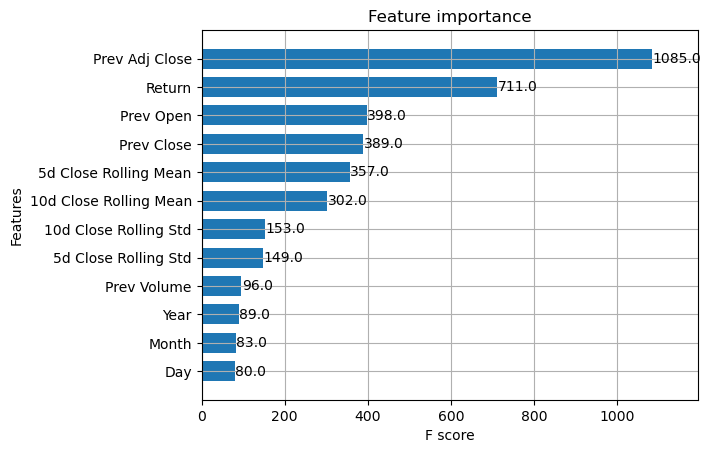

In [ ]:
#create a new df to analyze
df_eval = x_val.copy()
df_eval["Date"] = pd.to_datetime(df_eval[["Year", "Month", "Day"]])
df_eval.drop(["Year", "Month", "Day"], inplace = True, axis = 1)

df_eval.head()

,Prev Adj Close,Prev Volume,5d Close Rolling Mean,5d Close Rolling Std,10d Close Rolling Mean,10d Close Rolling Std,Prev Open,Prev Close,Return,Date
4411,2.325749,17.082643,130.929597,2.723072,133.029951,3.162299,2.303095,2.325749,0.002762,2022-02-28
4412,2.335130,17.205849,131.814299,3.210383,133.106051,3.200637,2.297005,2.335130,-0.005360,2022-03-01
4413,2.316874,17.019882,132.767399,3.016925,132.992850,3.133739,2.327216,2.316874,0.004349,2022-03-02
4414,2.331607,16.992147,134.200699,0.896516,132.825449,2.970454,2.330457,2.331607,-0.003291,2022-03-03
4415,2.320409,16.800182,134.527600,0.299915,132.507499,2.557443,2.365084,2.320409,-0.016276,2022-03-04


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

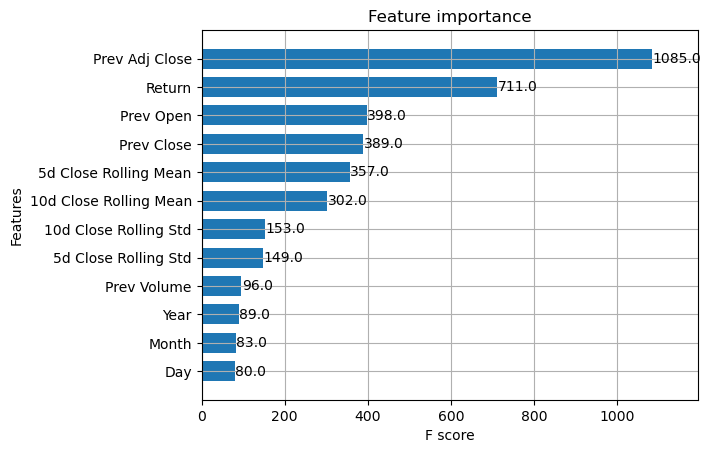

In [ ]:
xgb.plot_importance(model, height = 0.7)

## Predict and visualize results

In [ ]:
#predict the test set
df_eval["ClosePredictions"] = model.predict(x_val)


In [ ]:
df_eval.head()

,Prev Adj Close,Prev Volume,5d Close Rolling Mean,5d Close Rolling Std,10d Close Rolling Mean,10d Close Rolling Std,Prev Open,Prev Close,Return,Date,ClosePredictions
4411,2.325749,17.082643,130.929597,2.723072,133.029951,3.162299,2.303095,2.325749,0.002762,2022-02-28,134.840637
4412,2.335130,17.205849,131.814299,3.210383,133.106051,3.200637,2.297005,2.335130,-0.005360,2022-03-01,133.772583
4413,2.316874,17.019882,132.767399,3.016925,132.992850,3.133739,2.327216,2.316874,0.004349,2022-03-02,135.820236
4414,2.331607,16.992147,134.200699,0.896516,132.825449,2.970454,2.330457,2.331607,-0.003291,2022-03-03,134.928314
4415,2.320409,16.800182,134.527600,0.299915,132.507499,2.557443,2.365084,2.320409,-0.016276,2022-03-04,133.296417


In [ ]:
y_val.head()

,Close
4411,134.891006
4412,134.167999
4413,134.751495
4414,134.307999
4415,132.121994


In [ ]:
#combine prediction with the expected results

df_eval = pd.concat([df_eval, y_val], axis = 1)


df_eval.head()

,Prev Adj Close,Prev Volume,5d Close Rolling Mean,5d Close Rolling Std,10d Close Rolling Mean,10d Close Rolling Std,Prev Open,Prev Close,Return,Date,ClosePredictions,Close
4411,2.325749,17.082643,130.929597,2.723072,133.029951,3.162299,2.303095,2.325749,0.002762,2022-02-28,134.840637,134.891006
4412,2.335130,17.205849,131.814299,3.210383,133.106051,3.200637,2.297005,2.335130,-0.005360,2022-03-01,133.772583,134.167999
4413,2.316874,17.019882,132.767399,3.016925,132.992850,3.133739,2.327216,2.316874,0.004349,2022-03-02,135.820236,134.751495
4414,2.331607,16.992147,134.200699,0.896516,132.825449,2.970454,2.330457,2.331607,-0.003291,2022-03-03,134.928314,134.307999
4415,2.320409,16.800182,134.527600,0.299915,132.507499,2.557443,2.365084,2.320409,-0.016276,2022-03-04,133.296417,132.121994


In [ ]:
mse = mean_squared_error(
    y_true = df_eval["ClosePredictions"],
    y_pred = df_eval["Close"]
)

mae = mean_absolute_error(
    y_true = df_eval["ClosePredictions"],
    y_pred = df_eval["Close"]
)

rmse = np.sqrt(mse)

print(f"MSE:{mse}")
print(f"MAE:{mae}")
print(f"RSME:{rmse}")

MSE:3.2814182464488257
MAE:1.3616586910382993
RSME:1.811468533110312


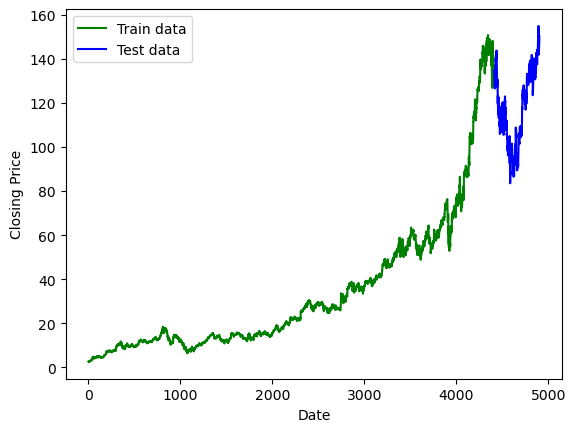

In [ ]:
#plot train and test data

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(train['Close'], 'green', label='Train data')
plt.plot(test['Close'], 'blue', label='Test data')
plt.legend()

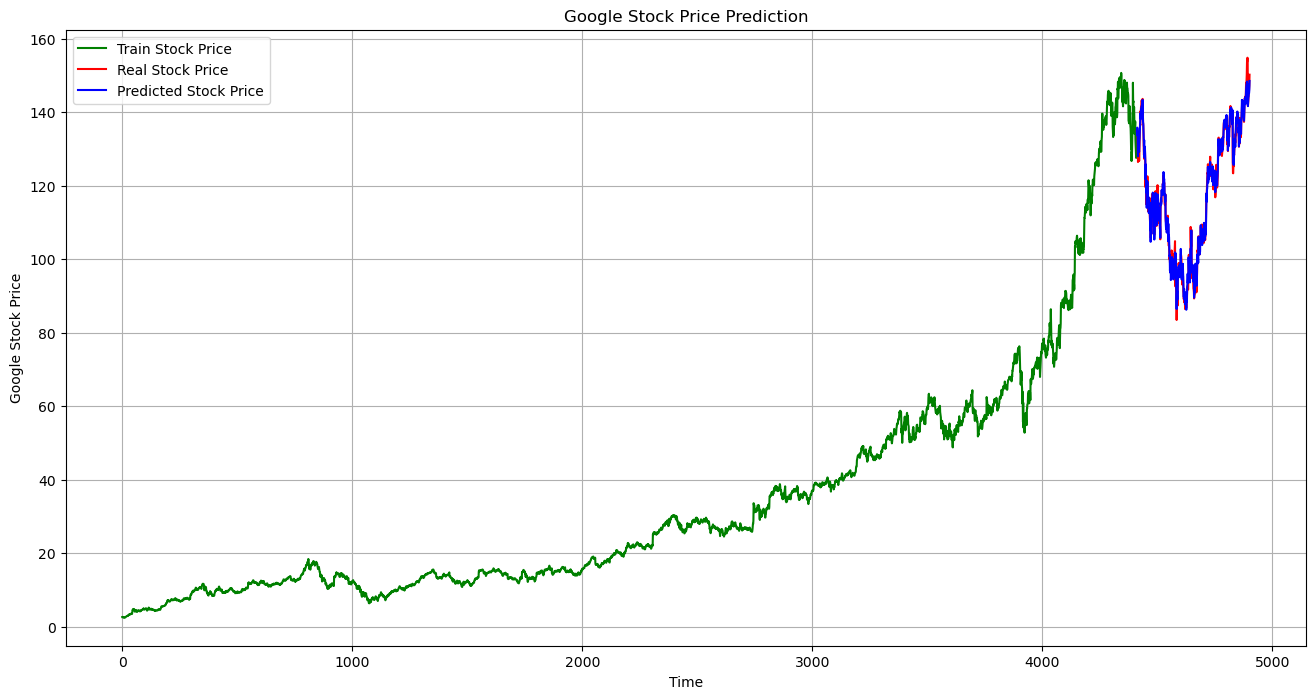

In [ ]:
#plot train, real, and predicted price

plt.figure(figsize=(16,8))
plt.plot(train.index, train['Close'], color='green', label = 'Train Stock Price')
plt.plot(test.index, test['Close'], color = 'red', label = 'Real Stock Price')
plt.plot(test.index, df_eval['ClosePredictions'], color = 'blue', label = 'Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.grid(True)

plt.show()

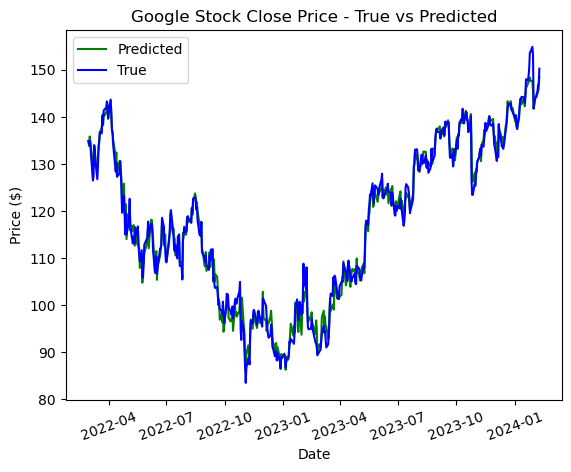

In [ ]:
#plot predicted against true

df_eval['Date'] = pd.to_datetime(df_xgboost['Date'])
df_eval.set_index('Date', inplace=True)

plt.title('Google Stock Close Price - True vs Predicted')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.plot(df_eval['ClosePredictions'], 'green', label='Predicted')
plt.plot(df_eval['Close'], 'blue', label='True')
plt.xticks(rotation=20)
plt.legend()

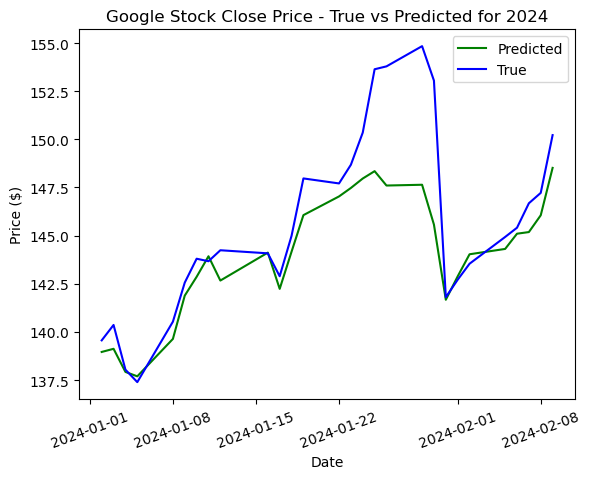

In [ ]:
#Plot predicted against true for 2024
df_eval['Date'] = pd.to_datetime(df_xgboost['Date'])
df_eval_2024_onwards = df_eval[df_eval.index.year >= 2024]

plt.title('Google Stock Close Price - True vs Predicted for 2024')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.plot(df_eval_2024_onwards['ClosePredictions'], 'green', label='Predicted')
plt.plot(df_eval_2024_onwards['Close'], 'blue', label='True')
plt.xticks(rotation=20)
plt.legend()
plt.show()